#                 Audio Classification of Capuchin Bird Clips

##  1. Loading Packages

In [ ]:
import os
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## 2. Method for Loading Data

In [ ]:
CAPUCHIN_FILE = os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips','XC114131-0.wav')
NOT_CAPUCHIN_FILE = os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')


### 2.1 Paths to Data Folders

In [ ]:
def load_wav_16k_mono(filename):

    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
capuchin = load_wav_16k_mono(CAPUCHIN_FILE)
not_capuchin = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

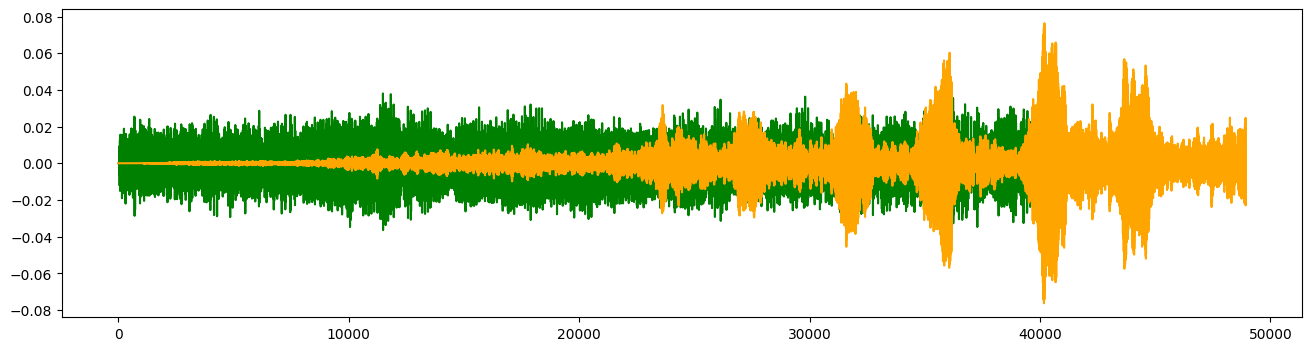

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(capuchin,color='green')
plt.plot(not_capuchin,color='orange')
plt.show()

## 3. Tensorflow Dataset

In [ ]:
Capuchin_folder = os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips')
not_Capuchin_folder = os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips')

In [ ]:
capuchin = tf.data.Dataset.list_files(Capuchin_folder + '/*-*.wav')
not_capuchin = tf.data.Dataset.list_files(not_Capuchin_folder + '/*-*.wav')

### 3.1 Adding labels to capuchin and not_capuchin samples

In [ ]:
capuchins = tf.data.Dataset.zip((capuchin, tf.data.Dataset.from_tensor_slices(tf.ones(len(capuchin)))))
not_capuchins = tf.data.Dataset.zip((not_capuchin, tf.data.Dataset.from_tensor_slices(tf.zeros(len(not_capuchin)))))

In [ ]:
data = capuchins.concatenate(not_capuchins)

## 4. Calculating the Avg Length of a Clip

## 4.1 calculate wave cycle length

In [ ]:
lengths = []
for file in os.listdir(os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips')):
    file_path = os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips', file)
    tensor_wave = load_wav_16k_mono(file_path)
    lengths.append(len(tensor_wave))


In [ ]:
max_length = tf.math.reduce_max(lengths)
mean_length = tf.math.reduce_mean(lengths)
min_length = tf.math.reduce_min(lengths)

print(f"Minimum Length : {min_length}")
print(f"Average Length : {mean_length}")
print(f"Maximum Length : {max_length}")

Minimum Length : 32000
Average Length : 54156
Maximum Length : 80000


## 5. Building Function to Convert wave to a Spectrogram

In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

### 5.1 Plot the Spectrogram

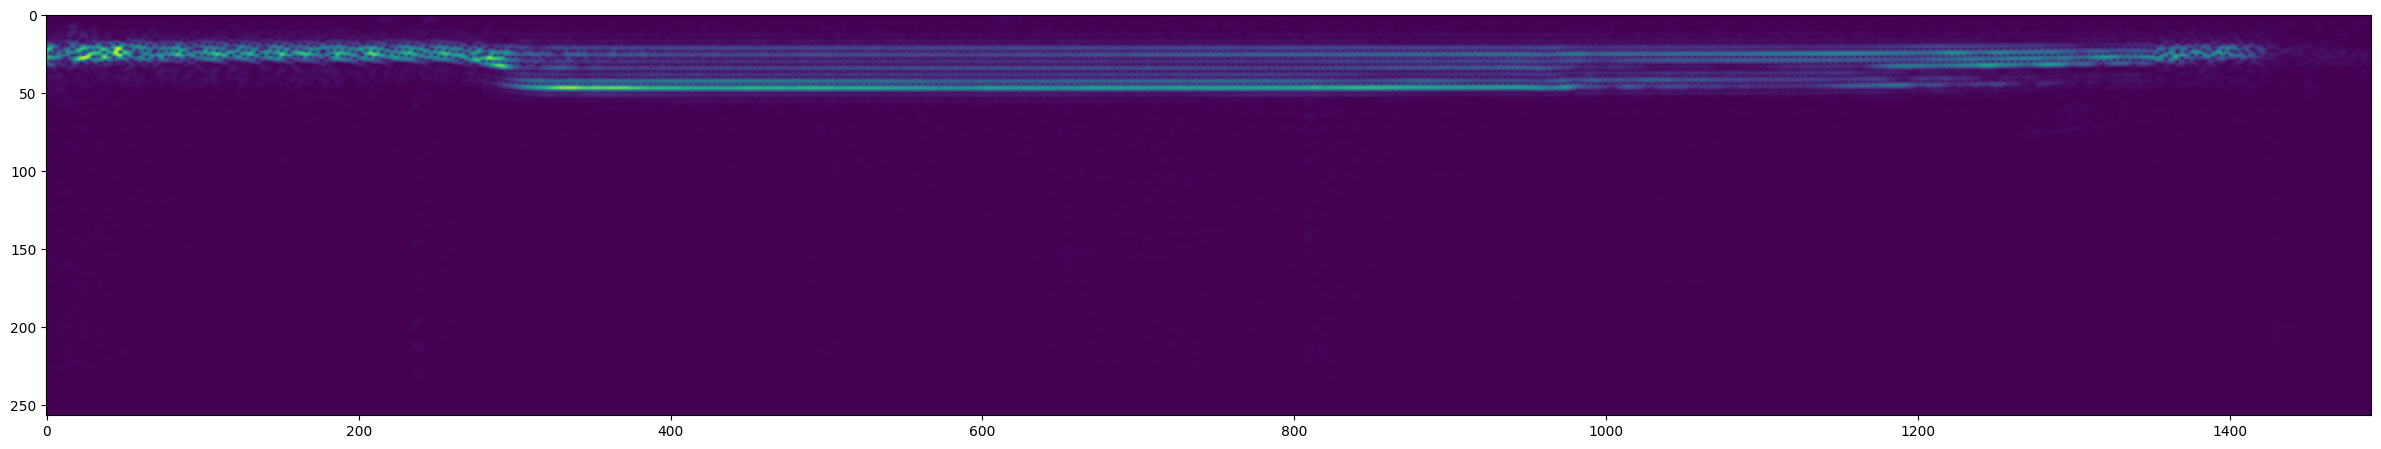

In [ ]:
filepath, label = capuchins.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## 6. Training and Testing Splits

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size = 10000)
data = data.batch(16)
data = data.prefetch(8)

### 6.1.  Split into training and testing data (70-30)

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

## 7. Building Deep Learning Model

### 7.1. Convolutional Neural Network

In [ ]:
model = Sequential()
model.add(Input(shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (2.87 GB)
Trainable params: 770482865 (2.87 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop, reduce_lr]

### 7.2. Model Fit

In [ ]:
hist = model.fit(
    train,
    epochs=15,
    validation_data=test,
    callbacks=callbacks)

Epoch 1/15
36/36 [==============================] - 20s 431ms/step - loss: 12.0898 - recall: 0.8598 - precision: 0.7877 - val_loss: 5.4577 - val_recall: 0.8209 - val_precision: 1.0000 - lr: 0.0010
Epoch 2/15
36/36 [==============================] - 11s 302ms/step - loss: 2.3626 - recall: 0.9481 - precision: 0.9542 - val_loss: 1.6850 - val_recall: 1.0000 - val_precision: 0.9655 - lr: 0.0010
Epoch 3/15
36/36 [==============================] - 11s 299ms/step - loss: 1.2836 - recall: 0.9726 - precision: 0.9793 - val_loss: 0.0124 - val_recall: 1.0000 - val_precision: 0.9846 - lr: 0.0010
Epoch 4/15
36/36 [==============================] - 10s 295ms/step - loss: 0.1529 - recall: 0.9936 - precision: 0.9936 - val_loss: 5.7423e-08 - val_recall: 1.0000 - val_precision: 1.0000 - lr: 0.0010
Epoch 5/15
36/36 [==============================] - 10s 295ms/step - loss: 1.0334e-08 - recall: 1.0000 - precision: 1.0000 - val_loss: 4.4920e-09 - val_recall: 1.0000 - val_precision: 1.0000 - lr: 0.0010
Epoch 6

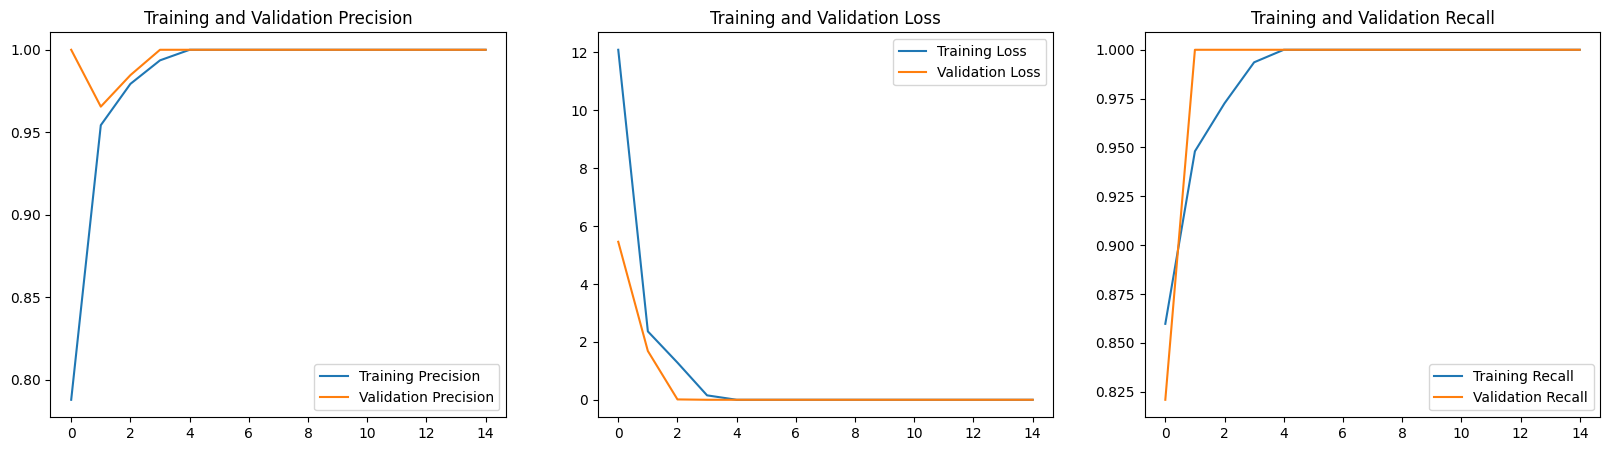

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.
    """
    prec = history.history['precision']
    val_prec = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(prec))

    plt.figure(figsize=(20, 5))

    # Plot training and validation Precision
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, prec, label='Training Precision')
    plt.plot(epochs_range, val_prec, label='Validation Precision')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Precision')

    # Plot training and validation loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')


    # Plot training and validation Recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, recall, label='Training Recall')
    plt.plot(epochs_range, val_recall, label='Validation Recall')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Recall')

    plt.show()

plot_training_history(hist)

## 8. Predictions Time

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

1/1 [==============================] - 0s 94ms/step


In [ ]:
# Converting Probabilities to Classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
y_test

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

In [ ]:
yhat

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]

## 9. Forest Clips Parsing

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

## 9.2 Build Function to convert clips into windowed spectrogram

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 10. Forect Clips Predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/', 'Forest Recordings')):
    FILEPATH = os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 [==============================] - 1s 596ms/step


In [ ]:
# Convert Predictions into Classes

class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_76.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_62.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_48.mp3': [0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_44.mp3': [0,
  0,
  0,
  

In [ ]:
from itertools import groupby

postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()

sorted_postprocessed = dict(sorted(postprocessed.items(), key=lambda item: item[1], reverse=True))

top_5 = dict(list(sorted_postprocessed.items())[:5])

print("Top 5 Recordings with most Capuchin Bird Sounds are : ",top_5)